In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

<h3>Data Prepration</h3>

In [2]:
df = pd.read_csv('CreditScoring.csv')

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [6]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [7]:
df.income.max()

np.int64(99999999)

In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan).max()

In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,959.0,300000.0,30000.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,0.0,0.0,0.0,475.0,628.0
min,0.0,6.0,18.0,35.0,959.0,300000.0,30000.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,959.0,300000.0,30000.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,959.0,300000.0,30000.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,959.0,300000.0,30000.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [10]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [11]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [16]:
del df_train['status']
del df_val['status']
del df_test['status']

<h3>Decision Tree</h3>

<h4>Simple decision tree</h4>

In [17]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [18]:
xi = df_train.iloc[0].to_dict()

In [19]:
assess_risk(xi)

'ok'

<h4>Decision tree from sklearn</h4>

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [21]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [22]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('tain:',auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:',auc)

tain: 0.7054989859726213
val: 0.6685264343319367


In [26]:
from sklearn.tree import export_text

In [27]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



<h3>Decision tree learning algorithm</h3>

In [28]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]
df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [29]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


<h4>Finding the best thershold for decision tree</h4>

In [30]:
Ts = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

In [31]:
from IPython.display import display

In [32]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print('--------------------')

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
--------------------
2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
--------------------
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
--------------------
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
--------------------
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
--------------------
6000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
--------------------
7000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
--------------------
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64
--------------------


In [33]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]
 
df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [34]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [35]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt' : [500, 1000, 2000]
}

In [36]:
for feature, Ts in thresholds.items():
    print('--------------------')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
    
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
    
        print('--------------------')

--------------------
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
--------------------
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
--------------------
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
--------------------
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
--------------------
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
--------------------
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64
--------------------
--------------------
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
--------------------
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64
--------------------
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64
--------------------


<h3>Decision tree parameters tuning</h3>

<p>
    - Selecting the 'max_depth'
</p>
<p>
    - Selecting the 'min_samples_leaf'
</p>

In [37]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    auc = round(auc,3)
    print(d,'->',auc)

1 -> 0.606
2 -> 0.669
3 -> 0.713
4 -> 0.719
5 -> 0.738
6 -> 0.746
10 -> 0.67
15 -> 0.648
20 -> 0.641
None -> 0.63


<p> 4, 5, 6 are the best ones</p>
<p>So for this values we have to calculate the samples leaf</p>

In [38]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, s, auc))

In [39]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [40]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
33,7.0,100,0.750775
19,6.0,2,0.748093
24,6.0,100,0.747297
23,6.0,20,0.746958
18,6.0,1,0.745989
...,...,...,...
46,15.0,2,0.661561
55,20.0,2,0.650063
45,15.0,1,0.645183
54,20.0,1,0.631808


In [41]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.623  0.719  0.738  0.746  0.733  0.677  0.645  0.632
2                 0.663  0.719  0.738  0.748  0.726  0.686  0.662  0.650
5                 0.691  0.719  0.737  0.745  0.733  0.705  0.692  0.697
10                0.717  0.719  0.735  0.742  0.729  0.718  0.719  0.717
15                0.727  0.717  0.729  0.741  0.731  0.732  0.727  0.729
20                0.730  0.718  0.732  0.747  0.740  0.725  0.730  0.730
100               0.746  0.726  0.734  0.747  0.751  0.746  0.746  0.746
200               0.743  0.725  0.735  0.743  0.743  0.743  0.743  0.743
500               0.674  0.674  0.674  0.674  0.674  0.674  0.674  0.674

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

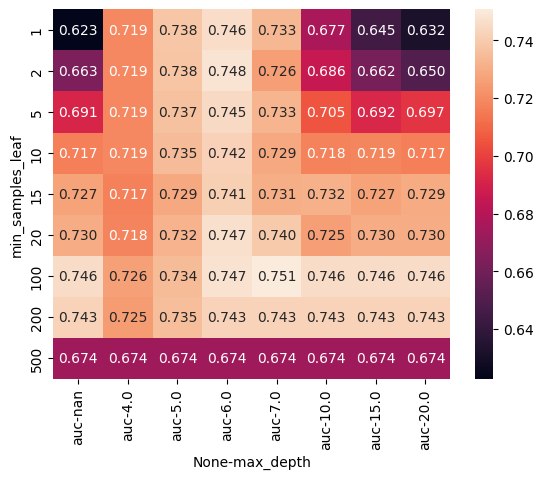

In [42]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [43]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


<h3>Ensembles and random forest</h3>

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [47]:
roc_auc_score(y_val, y_pred)

0.7367979705020464

In [48]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [49]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

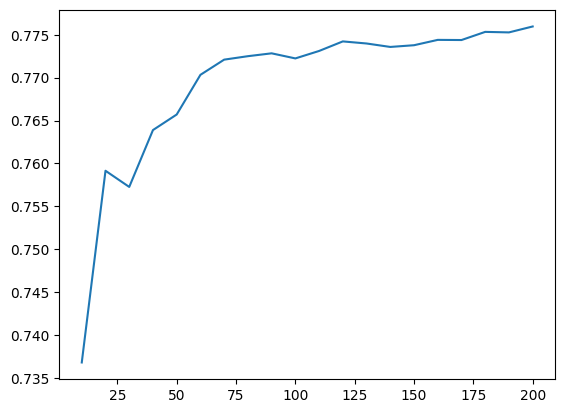

In [50]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [51]:
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train,y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [52]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.759663
1,5,20,0.768721
2,5,30,0.771748
3,5,40,0.774451
4,5,50,0.774291


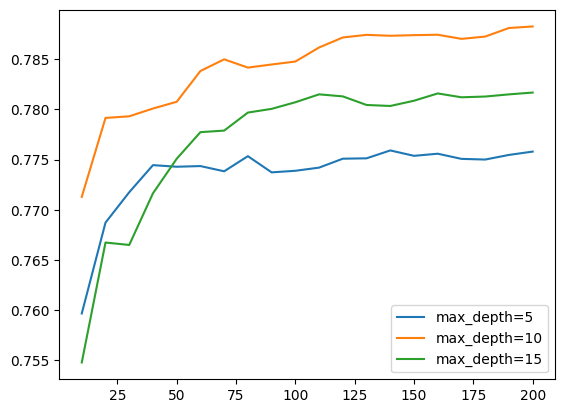

In [53]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' %d)

plt.legend()

In [54]:
max_depth = 10

In [55]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train,y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [56]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.771285
1,1,20,0.779156
2,1,30,0.779319
3,1,40,0.780094
4,1,50,0.780766


In [58]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

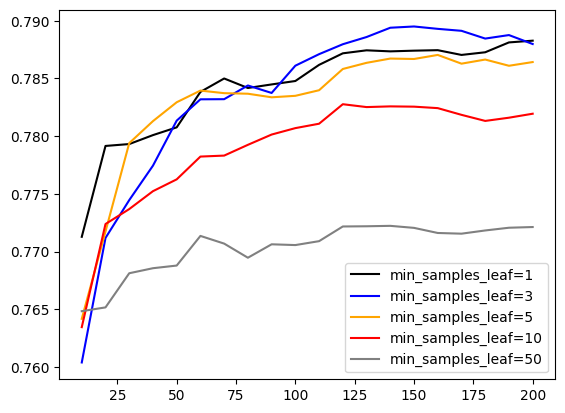

In [59]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
 
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
     
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
 
plt.legend()

In [60]:
min_samples_leaf = 3

In [62]:
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1, n_jobs=-1)
rf.fit(X_train,y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [63]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 47.7 MB/s  0:00:02 eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 49.4 MB/s  0:00:05 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]━━━ 1/2 [xgboost]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [65]:
import xgboost as xgb

In [67]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [68]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [75]:
xgb_params = {
    'eta' : 0.3,
    'max_depth' : 6,
    'min_child_weight' : 1,

    'objective' : 'binary:logistic',
    'nthread' : 2,

    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [76]:
y_pred = model.predict(dval)

In [77]:
roc_auc_score(y_val, y_pred)

0.7733495192656996

In [78]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [86]:
%%capture output
# This is capture the output inside a output variable
# One of the jupyter notebook features
xgb_params = {
    'eta' : 0.3,
    'max_depth' : 6,
    'min_child_weight' : 1,

    'objective' : 'binary:logistic',
    'eval_metric' : 'auc',
    'nthread' : 2,

    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [87]:
s = output.stdout
print(s)

[0]	train-auc:0.83894	val-auc:0.74952
[5]	train-auc:0.89952	val-auc:0.77561
[10]	train-auc:0.92891	val-auc:0.77452
[15]	train-auc:0.94455	val-auc:0.77274
[20]	train-auc:0.95398	val-auc:0.77355
[25]	train-auc:0.96589	val-auc:0.77188
[30]	train-auc:0.97194	val-auc:0.76901
[35]	train-auc:0.97596	val-auc:0.76978
[40]	train-auc:0.98190	val-auc:0.76897
[45]	train-auc:0.98712	val-auc:0.76719
[50]	train-auc:0.99037	val-auc:0.76400
[55]	train-auc:0.99294	val-auc:0.76330
[60]	train-auc:0.99380	val-auc:0.76290
[65]	train-auc:0.99568	val-auc:0.76200
[70]	train-auc:0.99669	val-auc:0.76127
[75]	train-auc:0.99747	val-auc:0.75874
[80]	train-auc:0.99835	val-auc:0.75603
[85]	train-auc:0.99872	val-auc:0.75471
[90]	train-auc:0.99903	val-auc:0.75318
[95]	train-auc:0.99930	val-auc:0.75409
[100]	train-auc:0.99953	val-auc:0.75649
[105]	train-auc:0.99963	val-auc:0.75726
[110]	train-auc:0.99972	val-auc:0.75741
[115]	train-auc:0.99980	val-auc:0.75591
[120]	train-auc:0.99990	val-auc:0.75551
[125]	train-auc:0.9999

In [94]:
s.split('\n')[0]

'[0]\ttrain-auc:0.83894\tval-auc:0.74952'

In [95]:
line = s.split('\n')[0]

In [96]:
line.split('\t')

['[0]', 'train-auc:0.83894', 'val-auc:0.74952']

In [97]:
num_iter, train_auc, val_auc = line.split('\t')

In [99]:
num_iter

'[0]'

In [100]:
num_iter.strip('[]')

'0'

In [101]:
int(num_iter.strip('[]'))

0

In [102]:
float(train_auc.split(':')[1])

0.83894

In [103]:
float(val_auc.split(':')[1])

0.74952

[0]	train-auc:0.83894	val-auc:0.74952
[5]	train-auc:0.89952	val-auc:0.77561
[10]	train-auc:0.92891	val-auc:0.77452
[15]	train-auc:0.94455	val-auc:0.77274
[20]	train-auc:0.95398	val-auc:0.77355
[25]	train-auc:0.96589	val-auc:0.77188
[30]	train-auc:0.97194	val-auc:0.76901
[35]	train-auc:0.97596	val-auc:0.76978
[40]	train-auc:0.98190	val-auc:0.76897
[45]	train-auc:0.98712	val-auc:0.76719
[50]	train-auc:0.99037	val-auc:0.76400
[55]	train-auc:0.99294	val-auc:0.76330
[60]	train-auc:0.99380	val-auc:0.76290
[65]	train-auc:0.99568	val-auc:0.76200
[70]	train-auc:0.99669	val-auc:0.76127
[75]	train-auc:0.99747	val-auc:0.75874
[80]	train-auc:0.99835	val-auc:0.75603
[85]	train-auc:0.99872	val-auc:0.75471
[90]	train-auc:0.99903	val-auc:0.75318
[95]	train-auc:0.99930	val-auc:0.75409
[100]	train-auc:0.99953	val-auc:0.75649
[105]	train-auc:0.99963	val-auc:0.75726
[110]	train-auc:0.99972	val-auc:0.75741
[115]	train-auc:0.99980	val-auc:0.75591
[120]	train-auc:0.99990	val-auc:0.75551
[125]	train-auc:0.9999

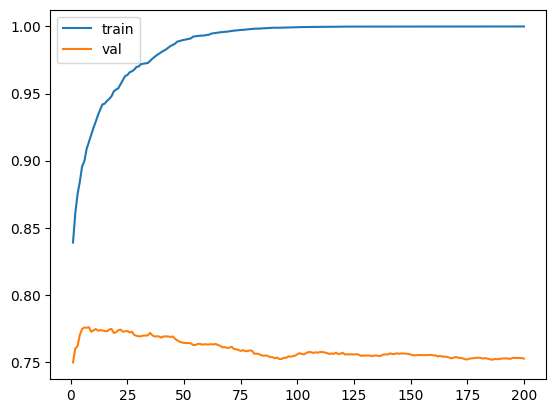

In [110]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=200,
    verbose_eval=5,
    evals=watchlist,
    evals_result=evals_result
)  # Remove the comma here

columns = ['iter', 'train_auc', 'val_auc']
train_aucs = list(evals_result['train'].values())[0]
val_aucs = list(evals_result['val'].values())[0]

df_scores = pd.DataFrame(
    list(zip(
        range(1, len(train_aucs) + 1),
        train_aucs,
        val_aucs
    )), columns=columns)

plt.plot(df_scores.iter, df_scores.train_auc, label='train')
plt.plot(df_scores.iter, df_scores.val_auc, label='val')
plt.legend()